In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time, datetime, psutil, os, timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from hypopt import GridSearch
from sklearn.linear_model import ElasticNet
import copy

In [81]:
# start measuring time 
start_time = time.time()

train = pd.read_csv('BPI_Challenge_2012-training.csv')
test = pd.read_csv('BPI_Challenge_2012-test.csv')

### **Functions concerning time**

In [82]:
def month(x):
    """Convert object to the month of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.month

def day(x):
    """Convert object to the day of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.day

def week(x):
    """Convert object to the week of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.week

def day_week(x):
    """Convert object to the day of week

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.weekday()

def time_of_day(x):
    """Convert object to the hour of the day

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.hour

### **Function 'time_conversion**

In [83]:
def time_conversion(dataframe):
    """Transform 'event time:timestamp' and 'case REG_DATE' from str to DateTime in a given Dataframe
        Additionally, this function creates timestamps for the start and finish of a task in a seperate column. 
        The difference between these timestaps is the time to complete a task, which is also added to the dataframe.

        Commented out lines are still for discussion
        
    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012

    Returns:
        dataframe_output: A pd.DataFrame with all the strings reformatted to DateTime in the 'event time:timestamp' and 'case REG_DATE' columns
    """
    
#     dataframe.drop(columns = ['eventID '], inplace=True) # Drop eventID
    dataframe.reset_index(inplace=True)
    
    #Transform 'event time:timestamp' and 'case REG_DATE' from str to DateTime  
    dataframe['case REG_DATE'] =  pd.to_datetime(dataframe['case REG_DATE'], format='%d-%m-%Y %H:%M:%S.%f')
    dataframe['event time:timestamp'] =  pd.to_datetime(dataframe['event time:timestamp'], format='%d-%m-%Y %H:%M:%S.%f')
    
    #Creates timestamps for the start and finish of a task in a seperate column + the time to complete the task.
    dataframe['timestamp_start'] = dataframe['case REG_DATE'].values.astype(np.int64) // 10 ** 9
    dataframe['timestamp_finish'] = dataframe['event time:timestamp'].values.astype(np.int64) // 10 ** 9 
#     dataframe['time_to_complete']= (dataframe["event time:timestamp"] - dataframe["case REG_DATE"])/10**6


    # Convert the timestamps of the event time to day of week, specific day and time of that day.
    
    dataframe["day_week"] = dataframe["event time:timestamp"].apply(day_week)
    # dataframe["week"] = dataframe["event time:timestamp"].apply(week)
#     dataframe["day_month"] = dataframe["event time:timestamp"].apply(day)
    # dataframe["month"] = dataframe["event time:timestamp"].apply(month)
    dataframe['time_of_day'] = dataframe['event time:timestamp'].apply(time_of_day)
    
    return dataframe

### ** Function 'encoding'**

In [84]:
def calculate_time_difference(dataframe):
    return dataframe.apply(lambda row: (row['next_time'] - row['event time:timestamp']).total_seconds(), axis=1)

def calculate_time_prev(dataframe):
    return dataframe.apply(lambda row: (row['event time:timestamp'] - row['prev_time']).total_seconds(), axis=1)

In [85]:
def encoding(dataframe):
    """Encoding 

    What kind of encoding is this exactly?
    
    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012

    Returns:
        dataframe: A pd.DataFrame with cases and events sorted wrt time, each event has a position within its case
    """
    # sort cases wrt time, for each case sort events 
    dataframe.sort_values(['timestamp_start',"timestamp_finish"], axis=0, ascending=True, inplace=True, ignore_index=True)
    
    # assign the position in the sequence to each event
    dataframe['position'] = None
    dataframe['position'] = dataframe.groupby('case concept:name').cumcount() + 1
    
    
    # create columns with previous and future (times of) events

   
    dataframe["prev_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(1)
    dataframe["2prev_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(2)
    dataframe["next_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(-1)

    dataframe["prev_time"] = dataframe.groupby("case concept:name")["event time:timestamp"].shift(1)
    dataframe["next_time"] = dataframe.groupby("case concept:name")["event time:timestamp"].shift(-1)
    
    
    dataframe["next_event"].fillna("LAST EVENT", inplace=True)
    dataframe["prev_event"].fillna("FIRST EVENT", inplace=True)
    dataframe["2prev_event"].fillna("FIRST EVENT", inplace=True)
    
    #     these values should be empty and filling them equals creating wrong data, but otherwise models dont work :( 
    dataframe["next_time"].fillna(method='ffill', inplace=True)
    dataframe["prev_time"].fillna(method='bfill', inplace=True)    
    
    dataframe['seconds_next'] = calculate_time_difference(dataframe)
    dataframe['seconds_prev'] = calculate_time_prev(dataframe)
    
    
        # how many events are left until the end of the case
    dataframe['position inverse'] = dataframe.groupby('case concept:name').cumcount(ascending=False)+1

    # how many cases start after the current event, inclusive
    dataframe['case start count'] = dataframe[dataframe['position'] == 1].groupby('position').cumcount(ascending=False) + 1

    # how many cases end before the current event, inclusive
    dataframe['case end count'] = dataframe[dataframe['position inverse'] == 1].groupby('position inverse').cumcount() + 1

    dataframe.at[-1, 'case start count'] = 0
    dataframe.at[0, 'case end count'] = 0
    dataframe['case start count'].fillna(method='bfill', inplace = True)
    dataframe['case end count'].fillna(method='ffill', inplace = True)
    
    
    total_cases = dataframe['case start count'].loc[0]
    dataframe['active cases'] = total_cases - dataframe['case start count'].shift(periods = -1, fill_value=0) - dataframe['case end count']
    dataframe.drop(dataframe.tail(1).index,inplace=True)
    
    return dataframe

### **Function: 'preprocessing'**

In [86]:
def preprocessing(dataframe):
    """Does all the processing needed for the naive estimator

    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012
    """
    pp_df = encoding(time_conversion(dataframe))
    
    
    return pp_df

## **Preprocessing and splitting**

In [87]:
# merge the data sets and preprocess
train = pd.concat([train, test], axis="rows", ignore_index=True)
train = preprocessing(train)
# test = preprocessing(test)

In [88]:
test = train.loc[220981:]
train = train.loc[:220981]

In [89]:
lst=['W_Wijzigen contractgegevens', 'W_Wijzigen contractgegevens', 'A_CANCELLED', 'W_Wijzigen contractgegevens']

train['event concept:name'].any() in lst

False

In [90]:
train_objs_num = train.shape[0]

dataset = pd.concat(objs=[train, test], axis=0)

train_data_filtered = copy.copy(dataset[:train_objs_num])
test = copy.copy(dataset[train_objs_num:])

val = train_data_filtered.loc[147054:]
train_data_filtered = train_data_filtered.loc[:147054]

first_val_event_timestamp = val['event time:timestamp'].min()
train_data_filtered = train_data_filtered.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_val_event_timestamp and g['event time:timestamp'].max() < first_val_event_timestamp)

first_test_event_timestamp = test['event time:timestamp'].min()
val = val.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_test_event_timestamp and g['event time:timestamp'].max() < first_test_event_timestamp)

In [91]:
# # Find the timestamp of the first event in the test set
# first_test_event_timestamp = test['event time:timestamp'].min()

# # Filter out cases that end after the first test event starts or start before the first train event ends
# train_data_filtered = train.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_test_event_timestamp and g['event time:timestamp'].max() < first_test_event_timestamp)

In [92]:
train.shape, test.shape

((220982, 25), (41219, 25))

In [93]:
train_data_filtered.shape, test.shape

((119925, 25), (41219, 25))

In [94]:
# first test event timestamp
first_test_event_timestamp

Timestamp('2012-02-07 20:30:15.364000')

### **Export dataframe to .CSV**

In [95]:
train_data_filtered.to_csv('preprocessed_train.csv')
test.to_csv('preprocessed_test.csv')

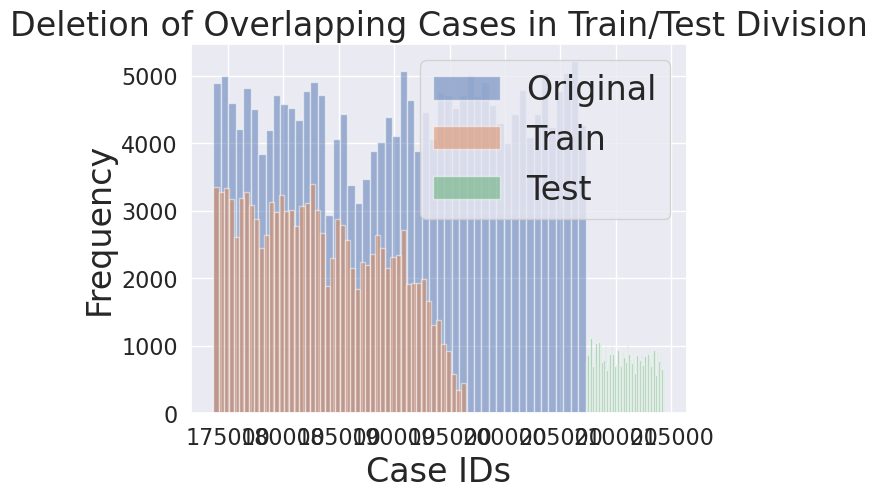

In [96]:
# Plot histogram of the feature in the original dataset
plt.hist(train['case concept:name'], bins=50, alpha=0.5, label='Original')

# Plot histogram of the feature in the training set
plt.hist(train_data_filtered['case concept:name'], bins=50, alpha=0.5, label='Train')

# Plot histogram of the feature in the testing set
plt.hist(test['case concept:name'], bins=50, alpha=0.5, label='Test')

# Add a title
plt.title('Deletion of Overlapping Cases in Train/Test Division', size=24)

# Add x and y axis labels
plt.xlabel('Case IDs', size=24)
plt.ylabel('Frequency', size=24)

# Enlarge x and y axis numbers
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set the legend location and size
plt.legend(loc='upper right', prop={'size': 24})

# Display the plot
plt.show()

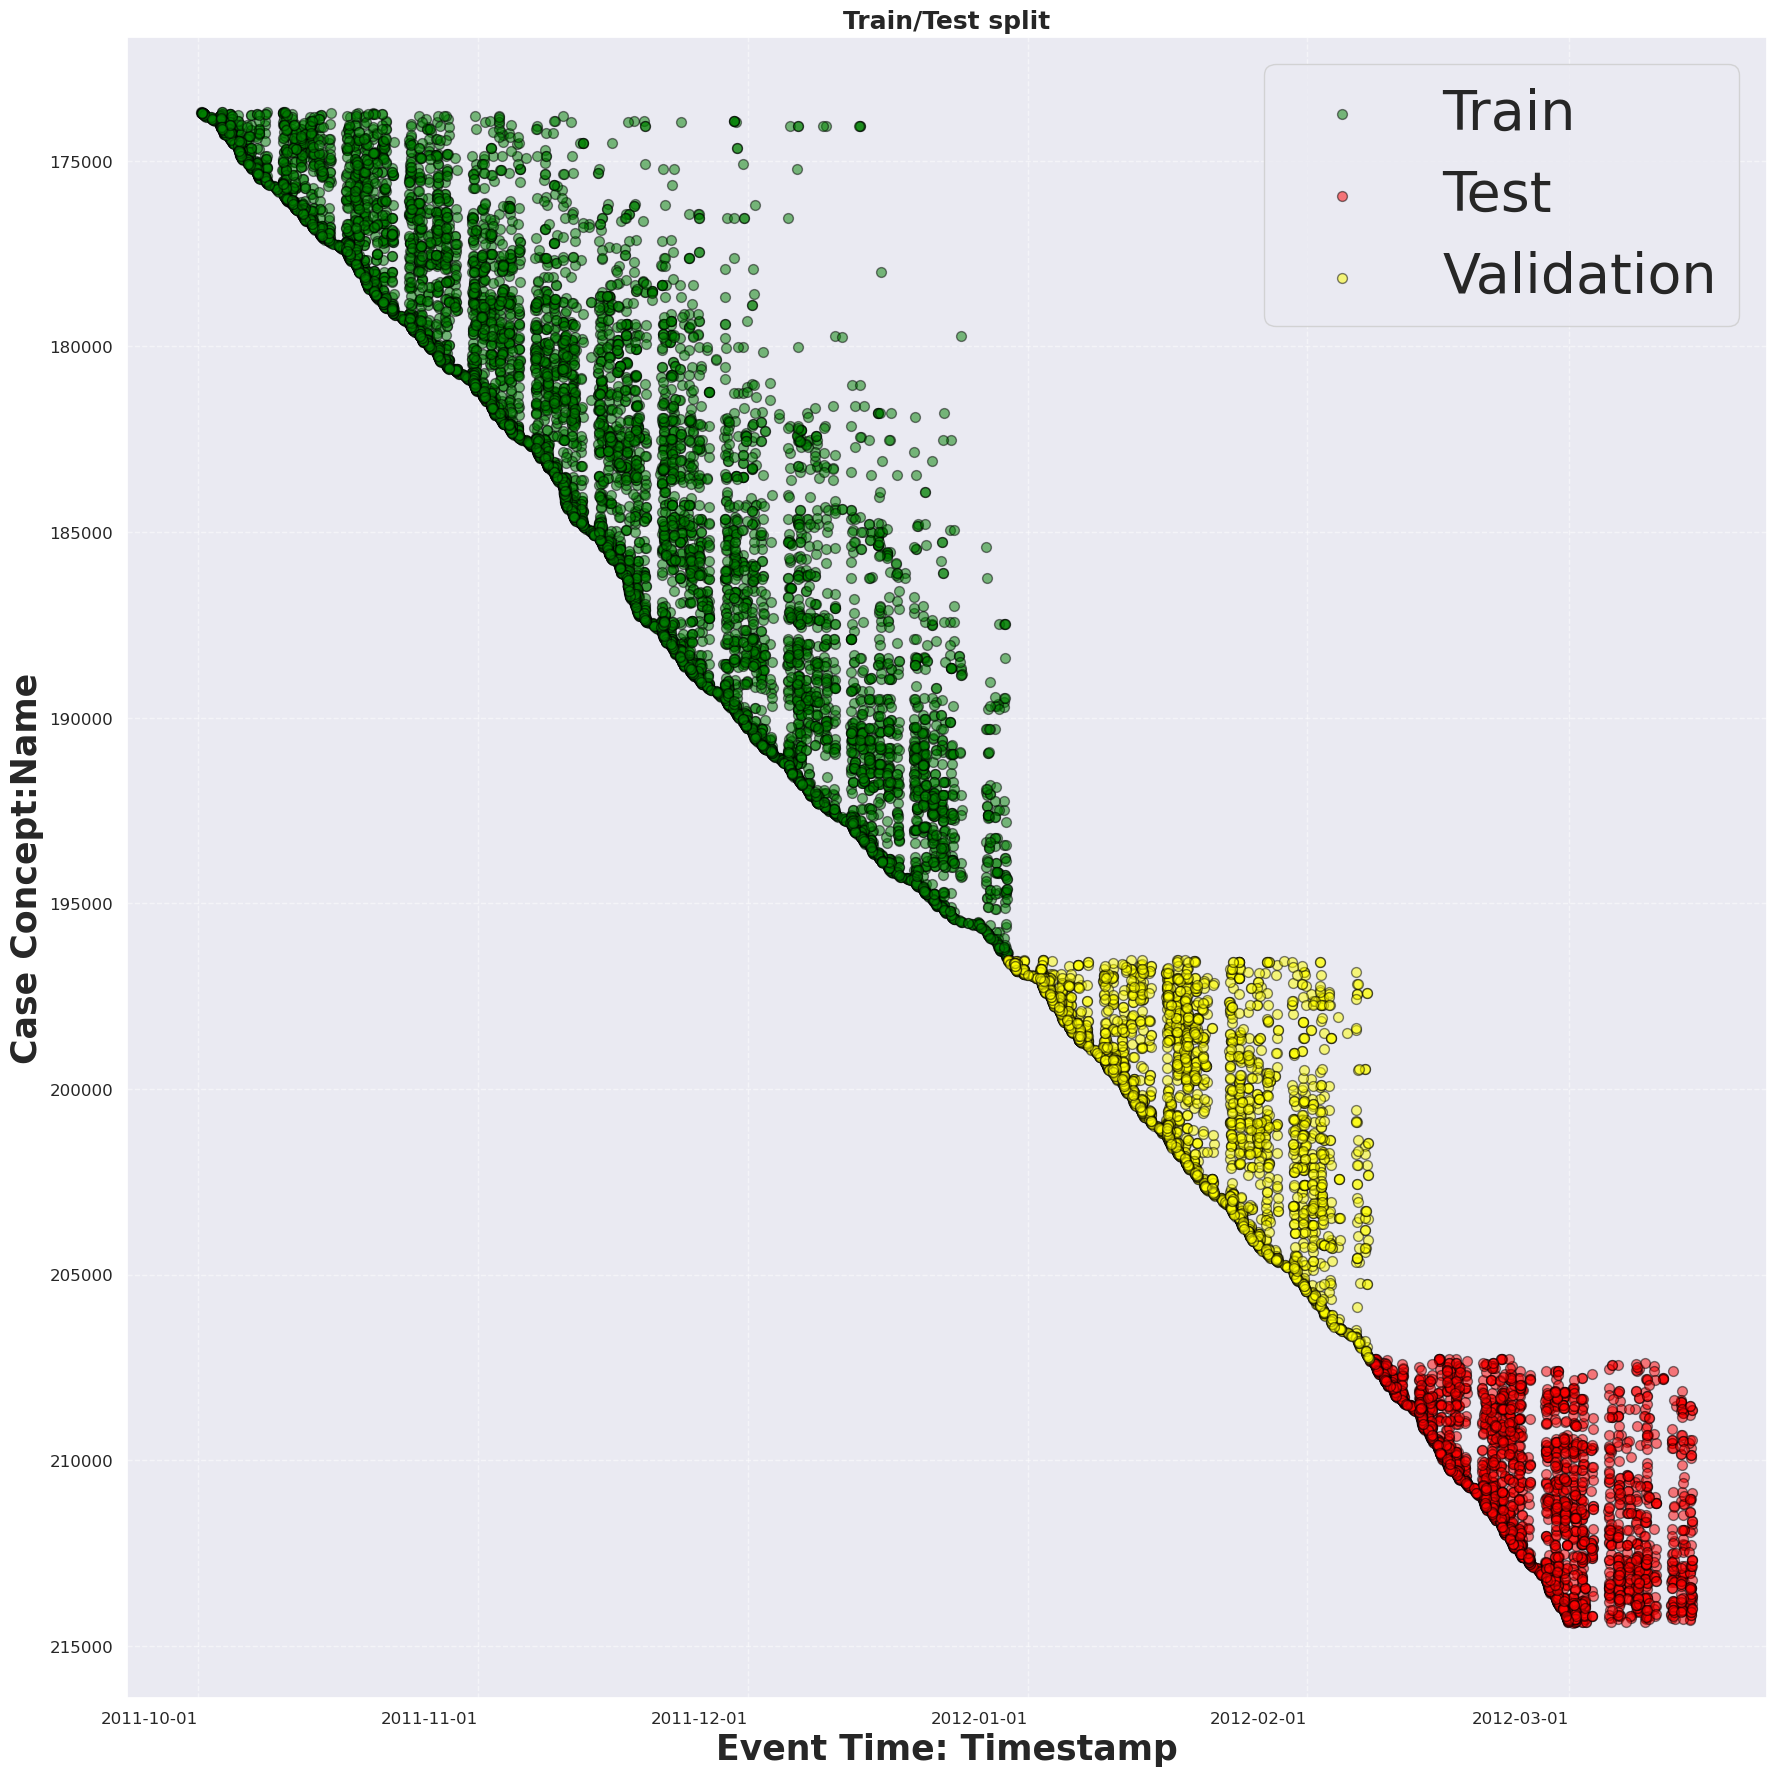

In [97]:
# Prepare the data
train_x = train_data_filtered['event time:timestamp'].sample(frac=0.1, replace=True, random_state=1)
train_y = train_data_filtered['case concept:name'].sample(frac=0.1, replace=True, random_state=1)

val_x = val['event time:timestamp'].sample(frac=0.1, replace=True, random_state=1)
val_y = val['case concept:name'].sample(frac=0.1, replace=True, random_state=1)

test_x = test['event time:timestamp'].sample(frac=0.1, replace=True, random_state=1)
test_y = test['case concept:name'].sample(frac=0.1, replace=True, random_state=1)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(18, 18))

ax.scatter(train_x, train_y, alpha=0.5, label='Train', color='green', s=50, edgecolors='black', linewidths=1)
ax.scatter(test_x, test_y, alpha=0.5, label='Test', color='red', s=50, edgecolors='black', linewidths=1)
ax.scatter(val_x, val_y, alpha=0.5, label='Validation', color='yellow', s=50, edgecolors='black', linewidths=1)


# Configure the x-axis
ax.set_xlabel('Event Time: Timestamp', fontsize=25, fontweight='bold')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0, ha='right', fontsize=12)

# Configure the y-axis
ax.set_ylabel('Case Concept:Name', fontsize=25, fontweight='bold')
ax.invert_yaxis()
plt.yticks(fontsize=12)

# Add a legend
ax.legend(loc='upper right', fontsize=40)

# Add a title
plt.title('Train/Test split', fontsize=18, fontweight='bold')

# Show grid
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

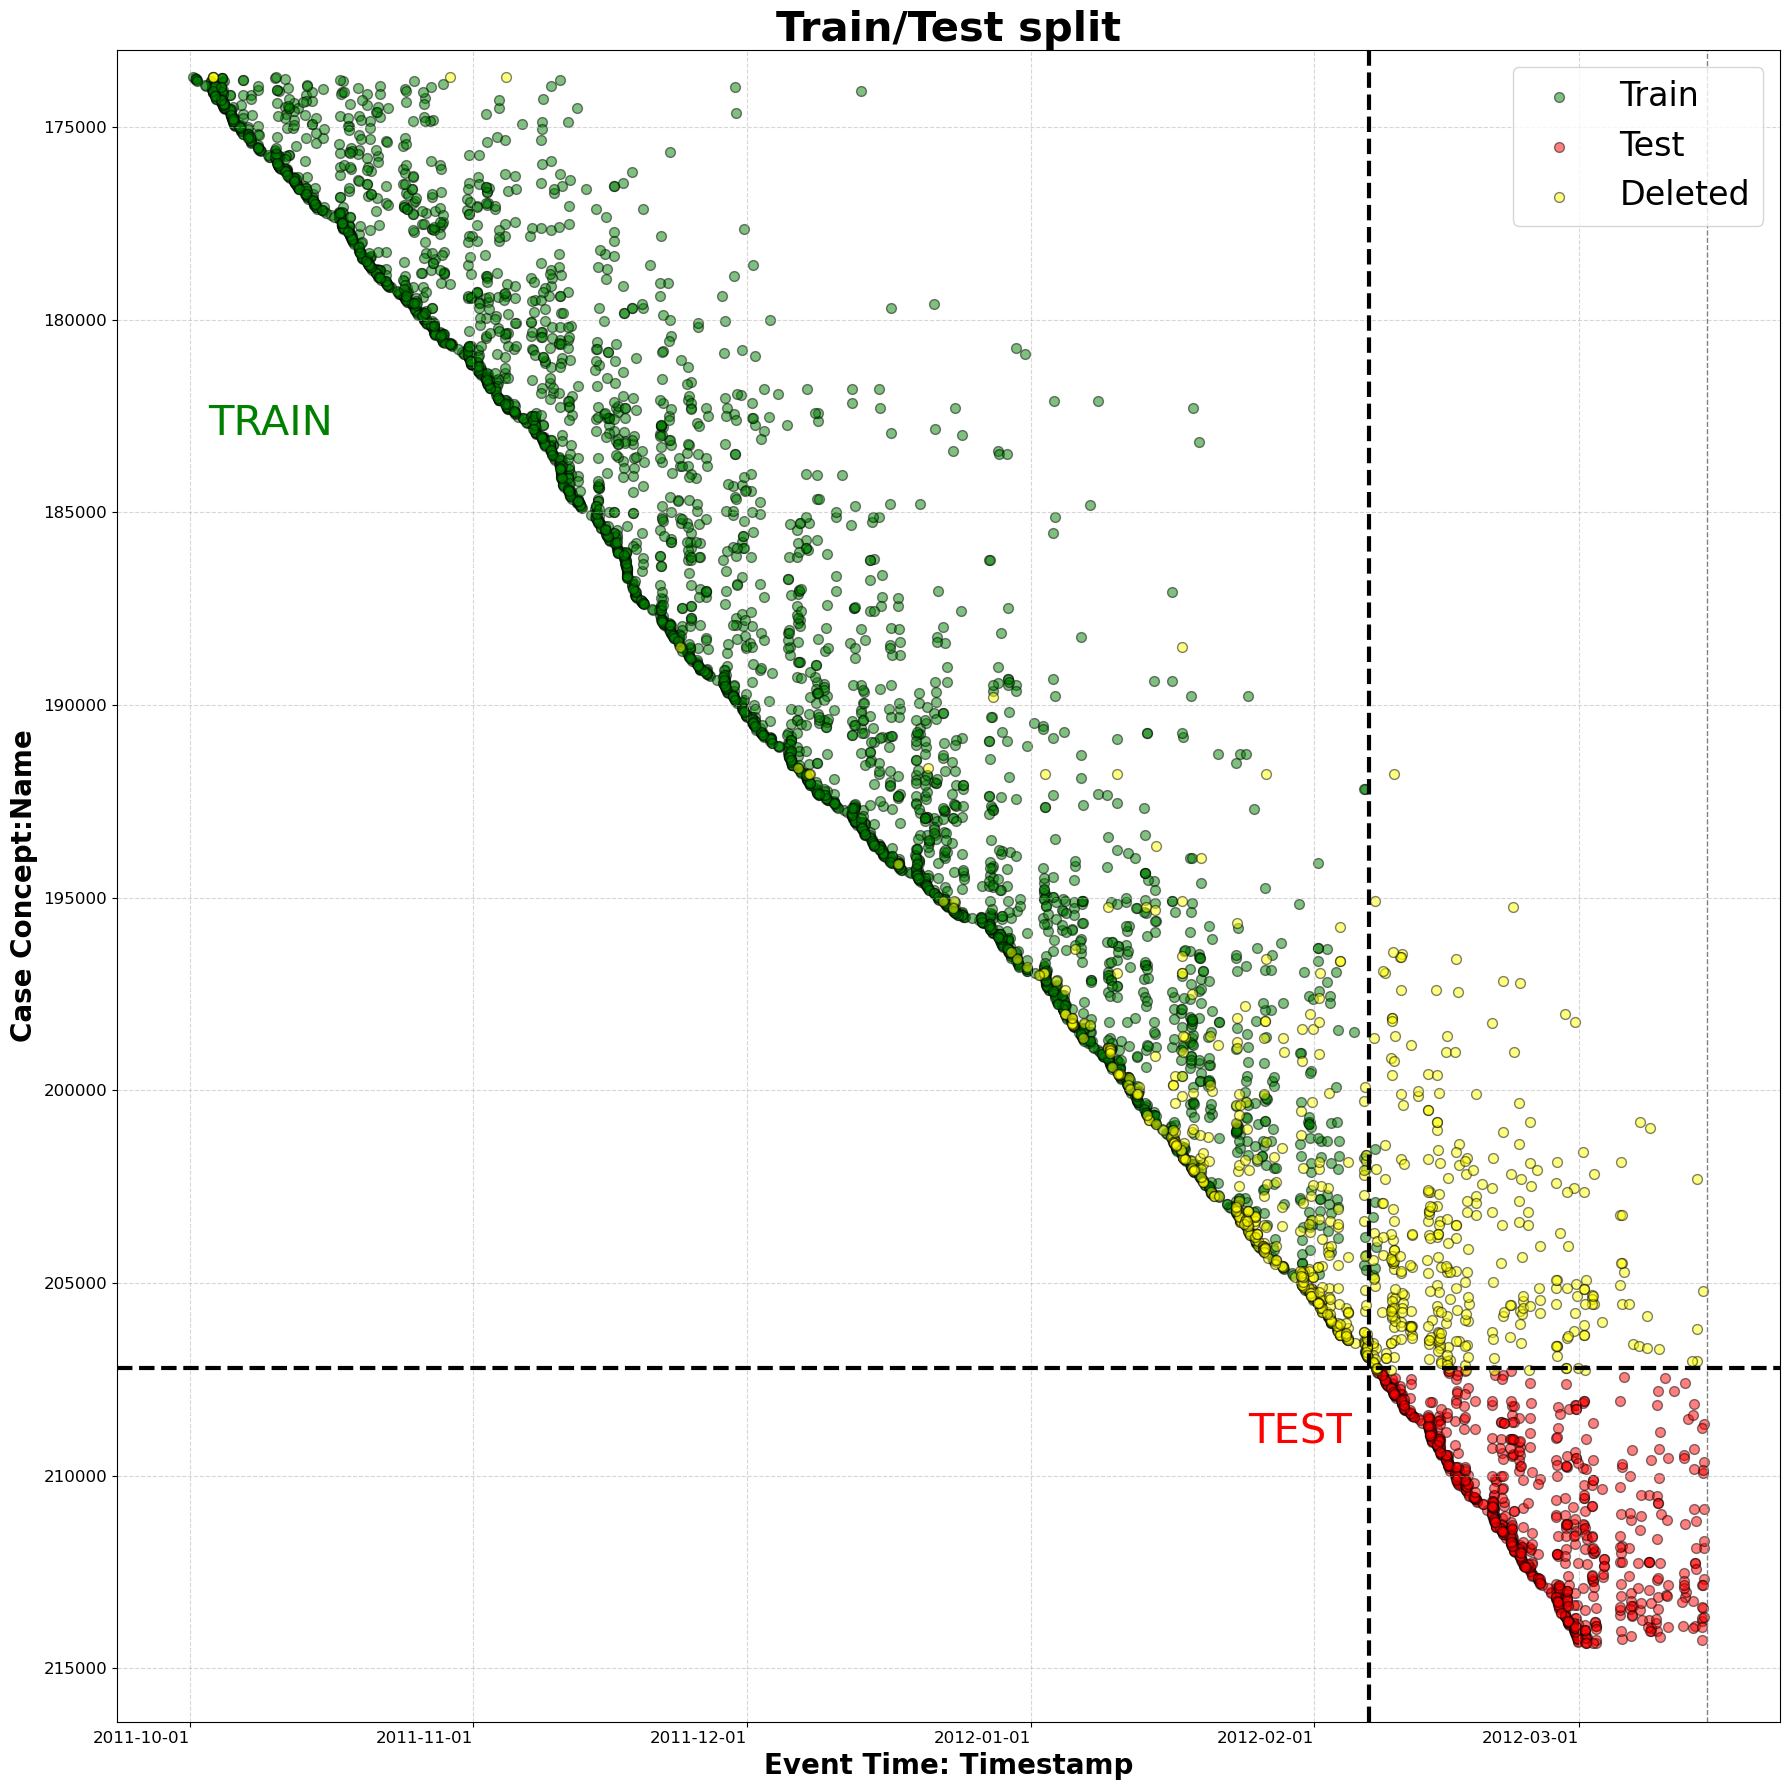

In [17]:
# # calculate deleted data
# deleted_data = train[~train['case concept:name'].isin(train_data_filtered['case concept:name'])]

# train_x = train_data_filtered['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1)
# train_y = train_data_filtered['case concept:name'].sample(frac=0.02, replace=True, random_state=1)

# test_x = test['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1)
# test_y = test['case concept:name'].sample(frac=0.02, replace=True, random_state=1)

# deleted_x = deleted_data['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1)
# deleted_y = deleted_data['case concept:name'].sample(frac=0.02, replace=True, random_state=1)

# fig, ax = plt.subplots(figsize=(18, 18))

# ax.scatter(train_x, train_y, alpha=0.5, label='Train', color='green', s=50, edgecolors='black', linewidths=1)
# ax.scatter(test_x, test_y, alpha=0.5, label='Test', color='red', s=50, edgecolors='black', linewidths=1)
# ax.scatter(deleted_x, deleted_y, alpha=0.5, label='Deleted', color='yellow', s=50, edgecolors='black', linewidths=1)

# # x axis
# ax.set_xlabel('Event Time: Timestamp', fontsize=20, fontweight='bold')
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.xticks(rotation=0, ha='right', fontsize=12)

# # y axis
# ax.set_ylabel('Case Concept:Name', fontsize=20, fontweight='bold')
# ax.invert_yaxis()
# plt.yticks(fontsize=12)
# ax.set_ylim(173000, ax.get_ylim()[0])
# ax.invert_yaxis()

# # legend
# ax.legend(loc='upper right', fontsize=24)

# # title
# plt.title('Train/Test split', fontsize=30, fontweight='bold')

# y_line = 1000 
# x_line = mdates.date2num(pd.Timestamp('2012-03-15'))  

# plt.axhline(y=y_line, color='gray', linestyle='--', linewidth=1)
# plt.axvline(x=x_line, color='gray', linestyle='--', linewidth=1)

# # x axis separation line
# vline_date = pd.Timestamp('2012-02-07')
# vline_x = mdates.date2num(vline_date)
# plt.axvline(x=vline_x, color='black', linestyle='--', linewidth=3)

# # y axis separation line
# hline_case = 207219
# plt.axhline(y=hline_case, color='black', linestyle='--', linewidth=3)

# # Add the label for the horizontal line
# label_yx = hline_case - 24000
# label_xx = ax.get_xlim()[0] + 10  
# plt.text(label_xx, label_yx, 'TRAIN', fontsize=30, color='green', rotation=0, ha='left', va='bottom')

# # label for line
# label_xy = ax.get_xlim()[0] + 135  
# label_yy = ax.get_ylim()[0] - 7000
# plt.text(label_xy, label_yy, 'TEST', fontsize=30, color='red', rotation=0, ha='right', va='bottom')

# # grid
# ax.grid(True, linestyle='--', alpha=0.5)

# # plot
# plt.tight_layout()
# plt.show()


In [18]:
df = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

# Naive estimator

In [19]:
case_ids=df["case concept:name"].unique()
event_types=df["event concept:name"].unique()

In [20]:
def make_dict(event_types):
    fn={}
    cnt={}
    bk={}
    for j in event_types:
        cnt[j]=0
    for j in event_types:
        fn[j]=cnt
    return fn
info=make_dict(event_types)       
    

In [21]:
case_ids=df["case concept:name"].unique()
def can():  #helper fucntion of naive_est
    fn={} #key position , value most popular event for this position
    dx=df[["index",'position',"event concept:name"]].groupby(["position","event concept:name"]).count().reset_index()
    m=df["position"].unique()
    for pos in m:
        val=dx[dx["position"]==pos]["index"].idxmax()
        pop=dx[dx["position"]==pos]["event concept:name"][val]
        fn[pos]=pop
    return fn


def  naive_est(case_ids):
    db=can()
    def predict(x):
        try:
            return db[x+1]
        except KeyError:
                return db[x]
    
    df["next_event"]= df["position"].apply(predict)
    
    example_df= df[df["case concept:name"]==case_ids[0]]
    return  example_df[["event concept:name",'next_event']].head(5)

naive_est(case_ids)    

,event concept:name,next_event
0,A_SUBMITTED,A_PARTLYSUBMITTED
1,A_PARTLYSUBMITTED,W_Afhandelen leads
2,A_PREACCEPTED,W_Afhandelen leads
3,W_Completeren aanvraag,W_Completeren aanvraag
4,W_Completeren aanvraag,W_Completeren aanvraag


In [22]:
mp={ j:index+1 for index, j in enumerate(event_types)}

def label_event(x):
    try:
        return mp[x]
    except KeyError:
        return 1
df["label_y"]= df["event concept:name"].apply(label_event)
df["label_ypred"]= df["next_event"].shift(1).apply(label_event)
df["label_ypred"].head()

0     1
1     2
2    20
3    20
4     4
Name: label_ypred, dtype: int64

In [23]:
y_actu = df["label_y"] 
y_pred = df["label_ypred"]

new_df=pd.DataFrame()
new_df["resu"]=y_actu.eq(y_pred)
new_df["pred"]=y_pred

def rev(x):
    if x==False:
        return 0
    if x==True:
        return 1
new_df["pred"]= new_df["resu"].apply(rev)
new_df["resu"]=new_df["resu"].apply(rev)


In [24]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(new_df["resu"],new_df["pred"], labels=[0, 1]).ravel()
print(tn, fp, fn, tp) 

sm= { "TP":[tp,0], "TN":[0,tn]}
dm= pd.DataFrame(sm,index=["TP","TN"])
dm

104991 0 0 78367


,TP,TN
TP,78367,0
TN,0,104991


Text(0.5, 0, 'Accuracy')

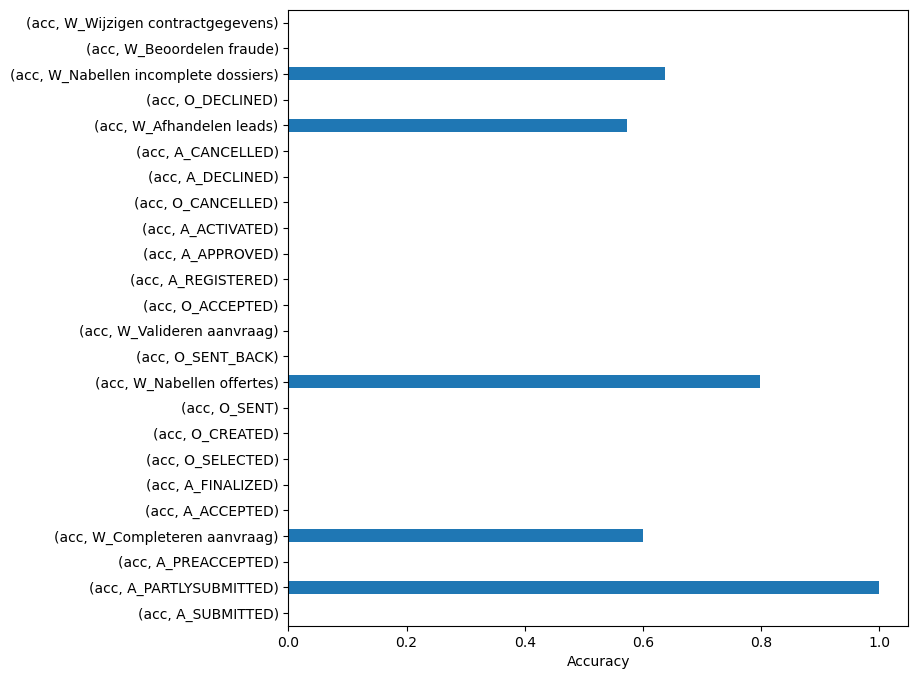

In [25]:
#plot acc per label
acc_label={}
for label in range(1,25):
    curr= df[df["label_y"]==label]
    y= curr["label_y"]
    yhat= curr["label_ypred"]
    p= y.eq(yhat).sum()
    psize= curr["label_y"].size
    acc_label[label]=  p/psize
    
    

pm= {mp[key]:key for key in mp}
fn_vis= {pm[key]: acc_label[key] for key in acc_label }

ax =pd.DataFrame(fn_vis,index=["acc"]).stack().plot(kind="barh",figsize=(8,8))
ax.set_xlabel("Accuracy")  

In [26]:
f1=f1_score(df["label_y"], df["label_ypred"], average='weighted')
glob_acc= (df["label_y"].eq(df["label_ypred"])).sum() /df["label_y"].size
pre =  precision_score(df["label_y"], df["label_ypred"], average='weighted')
recall=recall_score(df["label_y"], df["label_ypred"], average='weighted')
df_stats= pd.DataFrame( {"f1_score":f1, "Accurary":glob_acc,"Precision":pre,"Recall":recall},index=["baseline"])

df_stats

/home/konstantin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1_score,Accurary,Precision,Recall
baseline,0.330063,0.427399,0.363584,0.427399


## CPU/RAM usage

In [27]:
# start measuring CPU and memory usage
process = psutil.Process()

# start point
start_time = time.time()

naive_est(case_ids)

# end point
end_time = time.time()

# calculate time taken
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

# measure CPU and memory usage
cpu_usage = process.cpu_percent()
memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"CPU usage: {cpu_usage:.2f}%")
print(f"Memory usage: {memory_usage:.2f} MB")

Time taken: 0.19 seconds
CPU usage: 0.00%
Memory usage: 486.83 MB


# Naive estimator

In [28]:
train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

In [29]:
def naive_time_estimator(train, test):
    train['next position'] = train.groupby('case concept:name')['position'].shift(-1) #Creates new column with NaN values for the last even in a case
    test['next position'] = test.groupby('case concept:name')['position'].shift(-1)
    
    train = train.dropna(subset=['next position']) #Drop all last events per case
    
    train_position = train.groupby('position')['seconds_next'].mean()
    print(train_position)
    test['prediction_seconds'] = test.apply(lambda x: train_position[x['position']]
                                            if not pd.isnull(x['next position']) else np.nan, axis = 1)
    
    return test

naive_time_estimator(train, test)

position
1.0          0.573177
2.0         35.096267
3.0      10474.247829
4.0      11239.830887
5.0       1126.503860
             ...     
170.0       14.929000
171.0     1568.870000
172.0      304.951000
173.0        0.000000
174.0        3.406000
Name: seconds_next, Length: 174, dtype: float64


,Unnamed: 0,index,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event org:resource,event concept:name,event lifecycle:transition,event time:timestamp,...,prev_time,next_time,seconds_next,seconds_prev,position inverse,case start count,case end count,active cases,next position,prediction_seconds
0,220981,204226.0,4.629545e+13,207275.0,2012-02-07 20:30:15.364,20000.0,112.0,A_SUBMITTED,COMPLETE,2012-02-07 20:30:15.364,...,2012-02-07 20:30:15.364,2012-02-07 20:30:15.820,0.456,0.000,32.0,2308.0,10779.0,1.0,2.0,0.573177
1,220982,204227.0,4.629545e+13,207275.0,2012-02-07 20:30:15.364,20000.0,112.0,A_PARTLYSUBMITTED,COMPLETE,2012-02-07 20:30:15.820,...,2012-02-07 20:30:15.364,2012-02-07 20:30:58.911,43.091,0.456,31.0,2307.0,10779.0,1.0,3.0,35.096267
2,220983,204228.0,4.629545e+13,207275.0,2012-02-07 20:30:15.364,20000.0,112.0,A_PREACCEPTED,COMPLETE,2012-02-07 20:30:58.911,...,2012-02-07 20:30:15.820,2012-02-07 20:30:59.382,0.471,43.091,30.0,2307.0,10779.0,1.0,4.0,10474.247829
3,220984,204229.0,4.629545e+13,207275.0,2012-02-07 20:30:15.364,20000.0,112.0,W_Completeren aanvraag,SCHEDULE,2012-02-07 20:30:59.382,...,2012-02-07 20:30:58.911,2012-02-07 20:31:04.336,4.954,0.471,29.0,2307.0,10779.0,1.0,5.0,11239.830887
4,220985,204230.0,4.629545e+13,207275.0,2012-02-07 20:30:15.364,20000.0,10863.0,W_Completeren aanvraag,START,2012-02-07 20:31:04.336,...,2012-02-07 20:30:59.382,2012-02-07 20:35:34.190,269.854,4.954,28.0,2307.0,10779.0,1.0,6.0,1126.503860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41214,262195,236964.0,5.620394e+13,214376.0,2012-02-29 23:51:16.799,15000.0,112.0,A_PARTLYSUBMITTED,COMPLETE,2012-02-29 23:51:17.423,...,2012-02-29 23:51:16.799,2012-02-29 23:52:01.287,43.864,0.624,5.0,0.0,13086.0,1.0,3.0,35.096267
41215,262196,236965.0,5.620394e+13,214376.0,2012-02-29 23:51:16.799,15000.0,112.0,W_Afhandelen leads,SCHEDULE,2012-02-29 23:52:01.287,...,2012-02-29 23:51:17.423,2012-03-01 09:26:46.736,34485.449,43.864,4.0,0.0,13086.0,1.0,4.0,10474.247829
41216,262197,237062.0,5.620394e+13,214376.0,2012-02-29 23:51:16.799,15000.0,11169.0,W_Afhandelen leads,START,2012-03-01 09:26:46.736,...,2012-02-29 23:52:01.287,2012-03-01 09:27:37.118,50.382,34485.449,3.0,0.0,13086.0,1.0,5.0,11239.830887
41217,262198,237063.0,5.620394e+13,214376.0,2012-02-29 23:51:16.799,15000.0,11169.0,A_DECLINED,COMPLETE,2012-03-01 09:27:37.118,...,2012-03-01 09:26:46.736,2012-03-01 09:27:41.325,4.207,50.382,2.0,0.0,13086.0,1.0,6.0,1126.503860


In [30]:
def MAE(test):
    test2 = test.dropna(subset=['prediction_seconds','seconds_next'])
    
    y_pred = test2['prediction_seconds']
    y_true = test2['seconds_next']
    
    return mean_absolute_error(y_true, y_pred)

In [31]:
MAE(test)

55833.09206496625

In [32]:
# pip install hypopt 

In [33]:
train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

# Removing the last event from each case to reduce noise in the models

In [34]:
train.drop(train.groupby('case concept:name').tail(1).index, axis=0, inplace=True)
test.drop(test.groupby('case concept:name').tail(1).index, axis=0, inplace=True)

# Evaluation


In [35]:
def time_evaluation(y_test, y_pred, model: str):
    print('\n')
    print(f"Error metrics (measured in hours) for the {model} when predicting the next event's Unix timestamp")
    
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred)/3600,2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)/3600),2))
#     print('R2 score:', round(r2_score(y_test, y_pred),2))
    
    
def event_evaluation(y_test, y_pred, model: str, avg="weighted"):

    precision = precision_score(y_test, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg, zero_division=0)
    F1_score = f1_score(y_test, y_pred, average=avg, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    print('\n')
    print(f'Error metrics for the {model} when predicting the next event')
    
    print(f'Accuracy: {round(accuracy,2)}')
    print(f'Precision: {round(precision,2)}')
    print(f'Recall: {round(recall,2)}')
    print(f'f1-score: {round(F1_score,2)}')
#     print(confusion_matrix(y_test, y_pred))

# Data splitting and encoding

In [36]:
train_objs_num = train.shape[0]

dataset = pd.concat(objs=[train, test], axis=0)

dataset = dataset.replace({'event lifecycle:transition': {'SCHEDULE': 0, 'START': 1, 'COMPLETE': 2}})
dataset = pd.get_dummies(dataset, prefix = ['current', 'prev', '2prev'], 
                           columns = ['event concept:name', 'prev_event', '2prev_event'])

train_OHE = copy.copy(dataset[:train_objs_num])
test_OHE = copy.copy(dataset[train_objs_num:])



val_OHE = train_OHE.loc[147054:]
train_OHE = train_OHE.loc[:147054]

first_val_event_timestamp = val_OHE['event time:timestamp'].min()
train_OHE = train_OHE.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_val_event_timestamp and g['event time:timestamp'].max() < first_val_event_timestamp)

first_test_event_timestamp = test_OHE['event time:timestamp'].min()
val_OHE = val_OHE.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_test_event_timestamp and g['event time:timestamp'].max() < first_test_event_timestamp)


In [37]:
train_OHE.shape, val_OHE.shape, test_OHE.shape

((114600, 95), (33794, 95), (38911, 95))

In [38]:
lst = []
for element in list(train_OHE.columns):
    if element not in list(test_OHE.columns):
        lst.append(element)
print('event type that happen in the train but not the test set: ' + str(lst))

event type that happen in the train but not the test set: []


In [39]:
features_time = ['timestamp_finish', 'seconds_prev', 'active cases', 'day_week', 'time_of_day', 
                 'case AMOUNT_REQ', 'event lifecycle:transition', 
                 'current_A_ACCEPTED', 'current_A_ACTIVATED', 'current_A_APPROVED', 'current_A_CANCELLED', 'current_A_DECLINED', 'current_A_FINALIZED', 'current_A_PARTLYSUBMITTED', 'current_A_PREACCEPTED', 'current_A_REGISTERED', 'current_A_SUBMITTED', 'current_O_ACCEPTED','current_O_CANCELLED', 'current_O_CREATED', 'current_O_DECLINED','current_O_SELECTED', 'current_O_SENT', 'current_O_SENT_BACK','current_W_Afhandelen leads', 'current_W_Beoordelen fraude','current_W_Completeren aanvraag','current_W_Nabellen incomplete dossiers', 'current_W_Nabellen offertes','current_W_Valideren aanvraag', 'current_W_Wijzigen contractgegevens']

features_time_test = features_time.copy()

target_time = 'seconds_next'

features_event = ['active cases', 'day_week', 'time_of_day',  
                  'event lifecycle:transition', 'case AMOUNT_REQ', 
       'current_A_ACCEPTED', 'current_A_ACTIVATED', 'current_A_APPROVED','current_A_CANCELLED', 'current_A_DECLINED', 'current_A_FINALIZED','current_A_PARTLYSUBMITTED', 'current_A_PREACCEPTED','current_A_REGISTERED', 'current_A_SUBMITTED', 'current_O_ACCEPTED','current_O_CANCELLED', 'current_O_CREATED', 'current_O_DECLINED','current_O_SELECTED', 'current_O_SENT', 'current_O_SENT_BACK','current_W_Afhandelen leads', 'current_W_Beoordelen fraude','current_W_Completeren aanvraag','current_W_Nabellen incomplete dossiers', 'current_W_Nabellen offertes','current_W_Valideren aanvraag', 'current_W_Wijzigen contractgegevens','prev_A_ACCEPTED', 'prev_A_ACTIVATED', 'prev_A_APPROVED','prev_A_CANCELLED', 'prev_A_DECLINED', 'prev_A_FINALIZED','prev_A_PARTLYSUBMITTED', 'prev_A_PREACCEPTED', 'prev_A_REGISTERED','prev_A_SUBMITTED', 'prev_FIRST EVENT', 'prev_O_ACCEPTED', 'prev_O_CANCELLED', 'prev_O_CREATED', 'prev_O_DECLINED','prev_O_SELECTED', 'prev_O_SENT', 'prev_O_SENT_BACK','prev_W_Afhandelen leads', 'prev_W_Beoordelen fraude','prev_W_Completeren aanvraag', 'prev_W_Nabellen incomplete dossiers','prev_W_Nabellen offertes', 'prev_W_Valideren aanvraag','prev_W_Wijzigen contractgegevens', '2prev_A_ACCEPTED','2prev_A_ACTIVATED', '2prev_A_APPROVED', '2prev_A_CANCELLED','2prev_A_FINALIZED', '2prev_A_PARTLYSUBMITTED', '2prev_A_PREACCEPTED','2prev_A_REGISTERED', '2prev_A_SUBMITTED', '2prev_FIRST EVENT','2prev_O_ACCEPTED', '2prev_O_CANCELLED', '2prev_O_CREATED','2prev_O_SELECTED', '2prev_O_SENT', '2prev_O_SENT_BACK','2prev_W_Afhandelen leads', '2prev_W_Beoordelen fraude','2prev_W_Completeren aanvraag', '2prev_W_Nabellen incomplete dossiers','2prev_W_Nabellen offertes', '2prev_W_Valideren aanvraag','2prev_W_Wijzigen contractgegevens']

features_event_test = features_event.copy()

target_event = 'next_event'

# TIME
X_train_time = train_OHE[features_time]
y_train_time = train_OHE[target_time]

X_val_time = val_OHE[features_time]
y_val_time = val_OHE[target_time]

X_test_time = test_OHE[features_time_test].copy()
y_test_time = test_OHE[target_time]

# EVENT
X_train_event = train_OHE[features_event]
y_train_event = train_OHE[target_event]

X_val_event = val_OHE[features_event]
y_val_event = val_OHE[target_event]

X_test_event = test_OHE[features_event_test].copy()
y_test_event = test_OHE[target_event]

In [40]:
X_train_event.shape, X_train_time.shape, X_test_event.shape, X_test_time.shape

((114600, 77), (114600, 31), (38911, 77), (38911, 31))

# Event prediction

In [41]:
def RandomForestEvents(X_train, y_train, X_val, y_val):
    
    
    params={'max_depth': [10,15],
     'n_estimators': [200, 600, 900, 1400]}

    
    forest_clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_features='sqrt', random_state=42)    
    
    grid = GridSearchCV(estimator=forest_clf, param_grid=params, n_jobs=6)

    grid.fit(X_train, y_train)
    
    return grid.best_estimator_


In [42]:
rf_event = RandomForestEvents(X_train_event, y_train_event, X_val_event, y_val_event)

/home/konstantin/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [43]:
rf_event_train = rf_event.predict(X_train_event)
rf_event_val = rf_event.predict(X_val_event)
rf_event_test = rf_event.predict(X_test_event)

In [44]:
print(rf_event.get_params())

event_evaluation(y_train_event, rf_event_train, 'RF EVENT TRAIN')
event_evaluation(y_val_event, rf_event_val, 'RF EVENT VAL')
event_evaluation(y_test_event, rf_event_test, 'RF EVENT TEST')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 600, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Error metrics for the RF EVENT TRAIN when predicting the next event
Accuracy: 0.84
Precision: 0.85
Recall: 0.84
f1-score: 0.82


Error metrics for the RF EVENT VAL when predicting the next event
Accuracy: 0.8
Precision: 0.78
Recall: 0.8
f1-score: 0.77


Error metrics for the RF EVENT TEST when predicting the next event
Accuracy: 0.83
Precision: 0.8
Recall: 0.83
f1-score: 0.8


In [45]:
rf_event_features = dict(zip(features_event, rf_event.feature_importances_))

rf_event_features

# some categories of current, prev, 2prev event are very useful for next event -> current, prev, 2prev are good features

{'active cases': 9.334906955167905e-05,
 'day_week': 0.007381827673448484,
 'time_of_day': 0.02353109784514691,
 'event lifecycle:transition': 0.04446438846552574,
 'case AMOUNT_REQ': 0.01607920279624989,
 'current_A_ACCEPTED': 0.01265949065289792,
 'current_A_ACTIVATED': 0.0007861476614702207,
 'current_A_APPROVED': 0.0015444522068834886,
 'current_A_CANCELLED': 0.0044301886541508375,
 'current_A_DECLINED': 0.006011148811070773,
 'current_A_FINALIZED': 0.008330419199007533,
 'current_A_PARTLYSUBMITTED': 0.01200668273372736,
 'current_A_PREACCEPTED': 0.024662936908857618,
 'current_A_REGISTERED': 0.0007173013167272955,
 'current_A_SUBMITTED': 0.043721449145411394,
 'current_O_ACCEPTED': 0.002415898246404767,
 'current_O_CANCELLED': 0.005400178259172913,
 'current_O_CREATED': 0.029623550707016662,
 'current_O_DECLINED': 0.0012619891128230175,
 'current_O_SELECTED': 0.01406809727068153,
 'current_O_SENT': 0.014617934768572644,
 'current_O_SENT_BACK': 0.015261638457356333,
 'current_W_Afh

# Time prediction

In [46]:
def RandomForestTime(X_train, y_train, X_val, y_val):
    
    
    params={'max_depth': [10,15],
     'n_estimators': [200, 600, 1000, 1400]}

    forest_reg = RandomForestRegressor(bootstrap = True, max_features='sqrt', random_state=42)
    
    grid = GridSearchCV(estimator=forest_reg, param_grid=params, n_jobs=6)

    grid.fit(X_train, y_train)
    
    return grid.best_estimator_


In [47]:
rf_time = RandomForestTime(X_train_time, y_train_time, X_val_time, y_val_time)

/home/konstantin/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [48]:
rf_time_train = rf_time.predict(X_train_time)
rf_time_val = rf_time.predict(X_val_time)
rf_time_test = rf_time.predict(X_test_time)

In [49]:
print(rf_time.get_params())

time_evaluation(y_train_time, rf_time_train, 'RF TIME TRAIN')
time_evaluation(y_val_time, rf_time_val, 'RF TIME VAL')
time_evaluation(y_test_time, rf_time_test, 'RF TIME TEST')

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Error metrics (measured in hours) for the RF TIME TRAIN when predicting the next event's Unix timestamp
Mean Absolute Error: 10.08
Root Mean Squared Error: 1872.6


Error metrics (measured in hours) for the RF TIME VAL when predicting the next event's Unix timestamp
Mean Absolute Error: 8.35
Root Mean Squared Error: 1680.16


Error metrics (measured in hours) for the RF TIME TEST when predicting the next event's Unix timestamp
Mean Absolute Error: 9.67
Root Mean Squared Error: 1820.39


In [50]:
rf_time_features = dict(zip(features_time, rf_time.feature_importances_))

rf_time_features

# current event, current and prev time, note that active cases is relatively unimportant here too, mention cyclical time too

{'timestamp_finish': 0.03899795464964443,
 'seconds_prev': 0.21867630945836544,
 'active cases': 0.00015732032025762906,
 'day_week': 0.01962917099160595,
 'time_of_day': 0.022638339932082106,
 'case AMOUNT_REQ': 0.01411053140554309,
 'event lifecycle:transition': 0.2710644800559918,
 'current_A_ACCEPTED': 0.005301322915523864,
 'current_A_ACTIVATED': 0.00011033339275601374,
 'current_A_APPROVED': 0.0001067339329475809,
 'current_A_CANCELLED': 0.0005426802613448647,
 'current_A_DECLINED': 0.00526541252761679,
 'current_A_FINALIZED': 0.0018953029108498356,
 'current_A_PARTLYSUBMITTED': 0.008358295780993187,
 'current_A_PREACCEPTED': 0.010253750311193017,
 'current_A_REGISTERED': 0.00010450701284883481,
 'current_A_SUBMITTED': 0.007762604274105809,
 'current_O_ACCEPTED': 0.00024741430721528023,
 'current_O_CANCELLED': 0.0007555250076563175,
 'current_O_CREATED': 0.008227165683286587,
 'current_O_DECLINED': 3.8028858604558744e-05,
 'current_O_SELECTED': 0.004756200125145285,
 'current_O_S

# Elastic net

In [51]:
def ElasticNetTime(X_train, y_train, X_val, y_val):
    
    
    params = {"l1_ratio": [.1, .3 ,.5,.85,.95, .99, 1],
              'alpha':[0.1,0.3,0.5,0.7,0.9,1],
             'max_iter':[5000]}

#     params = {"l1_ratio": [.5],
#               'alpha':[.5]}


    en_reg = ElasticNet(random_state=42)
    
    grid = GridSearch(model=en_reg, param_grid=params, parallelize=False)

    grid.fit(X_train, y_train, X_val, y_val)
    
    return grid.best_estimator_


In [52]:
en_time = ElasticNetTime(X_train_time, y_train_time, X_val_time, y_val_time)

/home/konstantin/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.902e+14, tolerance: 2.173e+11
  model = cd_fast.enet_coordinate_descent(
/home/konstantin/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.430e+14, tolerance: 2.173e+11
  model = cd_fast.enet_coordinate_descent(
/home/konstantin/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

In [53]:
en_time_train = en_time.predict(X_train_time)
en_time_val = en_time.predict(X_val_time)
en_time_test = en_time.predict(X_test_time)

In [54]:
print(en_time.get_params())

time_evaluation(y_train_time, en_time_train, 'EN TIME TRAIN')
time_evaluation(y_val_time, en_time_val, 'EN TIME VAL')
time_evaluation(y_test_time, en_time_test, 'EN TIME TEST')

{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 5000, 'positive': False, 'precompute': False, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


Error metrics (measured in hours) for the EN TIME TRAIN when predicting the next event's Unix timestamp
Mean Absolute Error: 14.87
Root Mean Squared Error: 2062.91


Error metrics (measured in hours) for the EN TIME VAL when predicting the next event's Unix timestamp
Mean Absolute Error: 13.21
Root Mean Squared Error: 1763.51


Error metrics (measured in hours) for the EN TIME TEST when predicting the next event's Unix timestamp
Mean Absolute Error: 14.85
Root Mean Squared Error: 1910.4


In [55]:
en_time_features = dict(zip(features_time, en_time.coef_))

en_time_features

{'timestamp_finish': -0.0018044799370348806,
 'seconds_prev': -0.12771392983261082,
 'active cases': -17115.1339078041,
 'day_week': 2462.959586665164,
 'time_of_day': 508.96557994374314,
 'case AMOUNT_REQ': -0.0901703002446455,
 'event lifecycle:transition': 73065.88315895341,
 'current_A_ACCEPTED': -3164.846984221033,
 'current_A_ACTIVATED': 0.0,
 'current_A_APPROVED': 0.0,
 'current_A_CANCELLED': -338.15607263580614,
 'current_A_DECLINED': -1637.7733510191733,
 'current_A_FINALIZED': -3463.0402429491496,
 'current_A_PARTLYSUBMITTED': -4400.694989554175,
 'current_A_PREACCEPTED': -4000.6532679963443,
 'current_A_REGISTERED': 0.0,
 'current_A_SUBMITTED': -4436.050666937958,
 'current_O_ACCEPTED': 0.0,
 'current_O_CANCELLED': -1697.2092589281162,
 'current_O_CREATED': -3183.814207086083,
 'current_O_DECLINED': 0.0,
 'current_O_SELECTED': -3166.1231237556517,
 'current_O_SENT': -3184.009011715892,
 'current_O_SENT_BACK': 563.9645913306912,
 'current_W_Afhandelen leads': 87179.6961983147

In [56]:
# sorted elastic net features by absolute value
sorted(en_time_features.items(), key=lambda x: abs(x[1]), reverse=True)

[('current_W_Wijzigen contractgegevens', 193604.2740262987),
 ('current_W_Nabellen offertes', 165918.4732848595),
 ('current_W_Completeren aanvraag', 110349.71436998817),
 ('current_W_Beoordelen fraude', 93884.50763983198),
 ('current_W_Valideren aanvraag', 87240.10219458307),
 ('current_W_Afhandelen leads', 87179.69619831473),
 ('event lifecycle:transition', 73065.88315895341),
 ('current_W_Nabellen incomplete dossiers', 70999.67440897053),
 ('active cases', -17115.1339078041),
 ('current_A_SUBMITTED', -4436.050666937958),
 ('current_A_PARTLYSUBMITTED', -4400.694989554175),
 ('current_A_PREACCEPTED', -4000.6532679963443),
 ('current_A_FINALIZED', -3463.0402429491496),
 ('current_O_SENT', -3184.009011715892),
 ('current_O_CREATED', -3183.814207086083),
 ('current_O_SELECTED', -3166.1231237556517),
 ('current_A_ACCEPTED', -3164.846984221033),
 ('day_week', 2462.959586665164),
 ('current_O_CANCELLED', -1697.2092589281162),
 ('current_A_DECLINED', -1637.7733510191733),
 ('current_O_SENT_B

# Decision Tree event

In [57]:
def DecisionTreeEvent(X_train, y_train, X_val, y_val):


    params={'max_depth': [8, 16, 32, 64, 128, None]}

    tree_clf = DecisionTreeClassifier(random_state=42)
    
    grid = GridSearch(model=tree_clf, param_grid=params, parallelize=False)

    grid.fit(X_train, y_train, X_val, y_val)
    
    return grid.best_estimator_



In [58]:
dt_event = DecisionTreeEvent(X_train_event, y_train_event, X_val_event, y_val_event)

In [59]:
dt_event_train = dt_event.predict(X_train_event)
dt_event_val = dt_event.predict(X_val_event)
dt_event_test = dt_event.predict(X_test_event)

In [60]:
print(dt_event.get_params())

event_evaluation(y_train_event, dt_event_train, 'DT EVENT TRAIN')
event_evaluation(y_val_event, dt_event_val, 'DT EVENT VAL')
event_evaluation(y_test_event, dt_event_test, 'DT EVENT TEST')

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


Error metrics for the DT EVENT TRAIN when predicting the next event
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
f1-score: 0.92


Error metrics for the DT EVENT VAL when predicting the next event
Accuracy: 0.77
Precision: 0.78
Recall: 0.77
f1-score: 0.77


Error metrics for the DT EVENT TEST when predicting the next event
Accuracy: 0.79
Precision: 0.8
Recall: 0.79
f1-score: 0.8


In [61]:
dt_event_features = dict(zip(features_event, dt_event.feature_importances_))

dt_event_features

{'active cases': 0.00010871844903737872,
 'day_week': 0.03477333290806445,
 'time_of_day': 0.05001588810171122,
 'event lifecycle:transition': 0.031735095489763006,
 'case AMOUNT_REQ': 0.0747109996641813,
 'current_A_ACCEPTED': 0.003722387433179566,
 'current_A_ACTIVATED': 0.0028321635818129467,
 'current_A_APPROVED': 0.005153060018560649,
 'current_A_CANCELLED': 0.012628546753077013,
 'current_A_DECLINED': 0.009664028203280392,
 'current_A_FINALIZED': 2.0618446285064007e-05,
 'current_A_PARTLYSUBMITTED': 0.0,
 'current_A_PREACCEPTED': 0.031348989497806845,
 'current_A_REGISTERED': 0.0028197117630874803,
 'current_A_SUBMITTED': 0.07461430843886468,
 'current_O_ACCEPTED': 0.0057046432689246114,
 'current_O_CANCELLED': 0.010651903918637679,
 'current_O_CREATED': 0.035241001379647016,
 'current_O_DECLINED': 0.003864991157721397,
 'current_O_SELECTED': 0.02364483333639318,
 'current_O_SENT': 0.03067079519712621,
 'current_O_SENT_BACK': 0.026510106896761382,
 'current_W_Afhandelen leads': 1

In [62]:
dt_event.get_depth()

48

# Decision tree time

In [63]:
def DecisionTreeTime(X_train, y_train, X_val, y_val):

    params={'max_depth': [8, 16, 32, 64, 128, None]}

    tree_reg = DecisionTreeRegressor(random_state=42)
    
    grid = GridSearch(model=tree_reg, param_grid=params, parallelize=False)

    grid.fit(X_train, y_train, X_val, y_val)
    
    return grid.best_estimator_



In [64]:
dt_time = DecisionTreeTime(X_train_time, y_train_time, X_val_time, y_val_time)

In [65]:
dt_time_train = dt_time.predict(X_train_time)
dt_time_val = dt_time.predict(X_val_time)
dt_time_test = dt_time.predict(X_test_time)

In [66]:
print(dt_time.get_params())

time_evaluation(y_train_time, dt_time_train, 'DT TIME TRAIN')
time_evaluation(y_val_time, dt_time_val, 'DT TIME VAL')
time_evaluation(y_test_time, dt_time_test, 'DT TIME TEST')

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


Error metrics (measured in hours) for the DT TIME TRAIN when predicting the next event's Unix timestamp
Mean Absolute Error: 0.0
Root Mean Squared Error: 0.0


Error metrics (measured in hours) for the DT TIME VAL when predicting the next event's Unix timestamp
Mean Absolute Error: 8.51
Root Mean Squared Error: 2144.71


Error metrics (measured in hours) for the DT TIME TEST when predicting the next event's Unix timestamp
Mean Absolute Error: 10.46
Root Mean Squared Error: 2437.06


In [67]:
dt_time_features = dict(zip(features_time, dt_time.feature_importances_))

dt_time_features

# active cases is stronger here

{'timestamp_finish': 0.23962835446678846,
 'seconds_prev': 0.26845009944900255,
 'active cases': 2.6598954273848013e-05,
 'day_week': 0.04319766516686453,
 'time_of_day': 0.06713960325460212,
 'case AMOUNT_REQ': 0.10742254715992985,
 'event lifecycle:transition': 0.19109721843033695,
 'current_A_ACCEPTED': 4.526081227121613e-08,
 'current_A_ACTIVATED': 9.846036174484638e-13,
 'current_A_APPROVED': 9.293739238948245e-10,
 'current_A_CANCELLED': 1.0483483238714457e-08,
 'current_A_DECLINED': 6.793258404359789e-12,
 'current_A_FINALIZED': 3.530755546345277e-12,
 'current_A_PARTLYSUBMITTED': 3.1007354571091227e-09,
 'current_A_PREACCEPTED': 1.2960836668157854e-13,
 'current_A_REGISTERED': 6.767325317465853e-13,
 'current_A_SUBMITTED': 9.69010595870739e-12,
 'current_O_ACCEPTED': 2.1815938023722803e-13,
 'current_O_CANCELLED': 1.0887550846967718e-12,
 'current_O_CREATED': 1.54665312281492e-16,
 'current_O_DECLINED': 4.950656997995058e-13,
 'current_O_SELECTED': 2.768484883306311e-12,
 'curr

In [68]:
dt_time.get_depth()

53

## Time, Memory and CPU usage

### Memory and CPU usage

### Time usage

# Visualizations

### Confusion matrix for Random Forest estimator

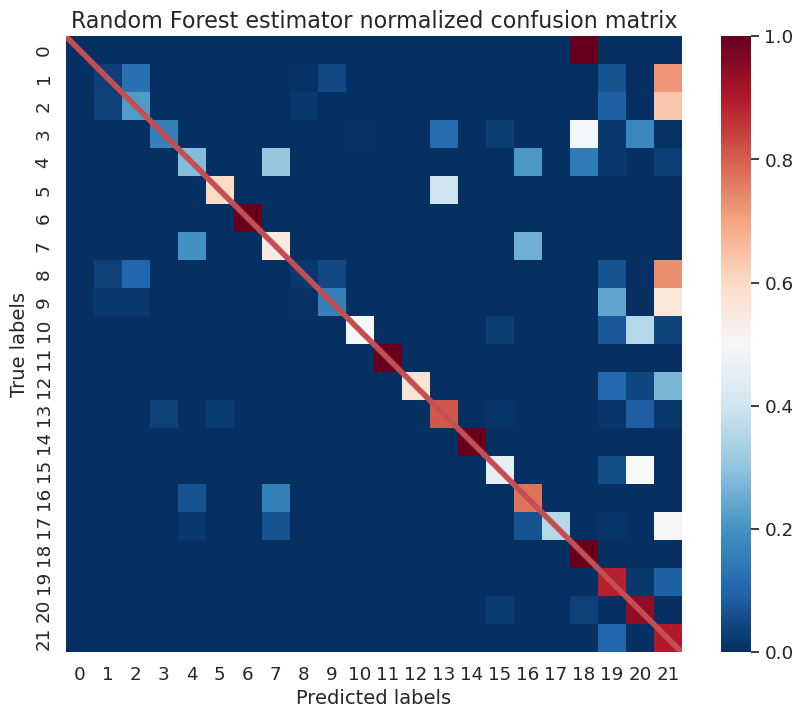

In [69]:
# # Random Forest estimator on test set

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_event, rf_event_test, normalize='true')

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w')
sns.heatmap(cm, fmt='g', cmap='RdBu_r', ax=ax, annot_kws={"size": 14}, square=True)

# # Draw a diagonal line
# n_classes = cm.shape[0]
# for i in range(n_classes):
#     ax.plot([i, i + 1], [i + 1, i], color='black', linewidth=1)
# ax.hlines([j for j in range(25)], *ax.get_xlim())
# ax.vlines([j for j in range(25)], *ax.get_ylim())
ax.axline((1, 1), (24, 24), linewidth=4, color='r')

ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest estimator normalized confusion matrix', fontsize=16)
plt.show()



### Bar chart for feature importance of Random Forest event estimator

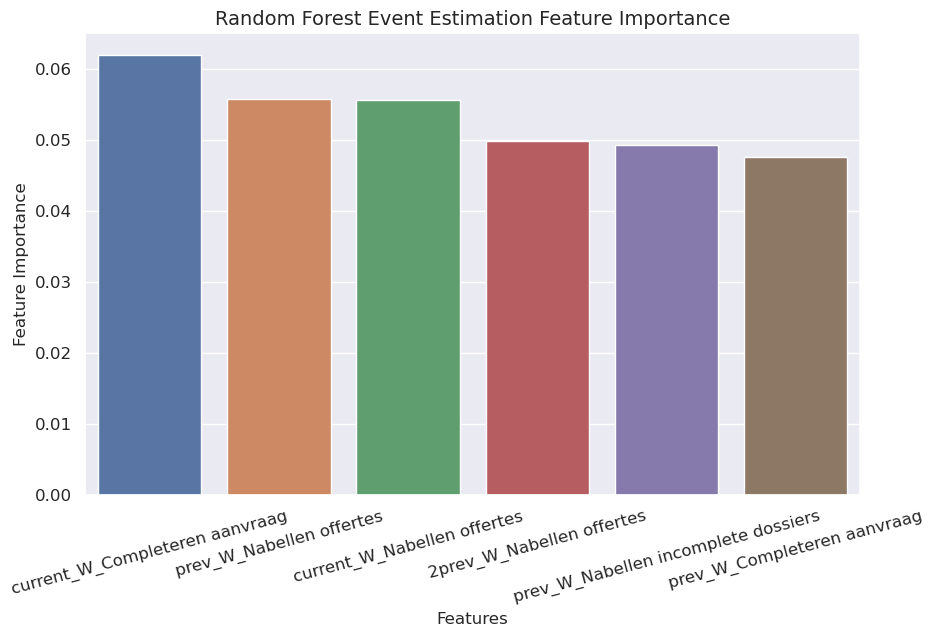

In [70]:
def filter_features(features, threshold):
    sorted_features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    return {k: v for k, v in sorted_features.items() if v > threshold}

def bar_plot(data, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=list(data.keys()), y=list(data.values()), ax=ax)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    plt.xticks(rotation=15, fontsize=12)  # Rotate x-labels and increase font size
    plt.yticks(fontsize=12)  # Increase y-labels font size
    plt.show()

important_features = filter_features(rf_event_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Random Forest Event Estimation Feature Importance')


### Bar chart feature importance Random Forest time estimator

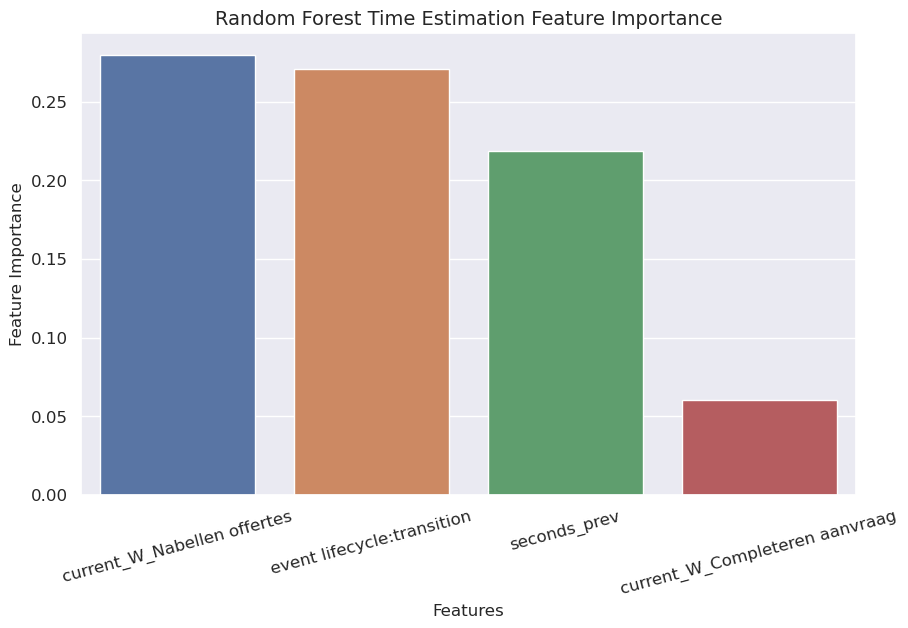

In [71]:
important_features = filter_features(rf_time_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Random Forest Time Estimation Feature Importance')


### Bar chart feature importance Decision Tree time estimator

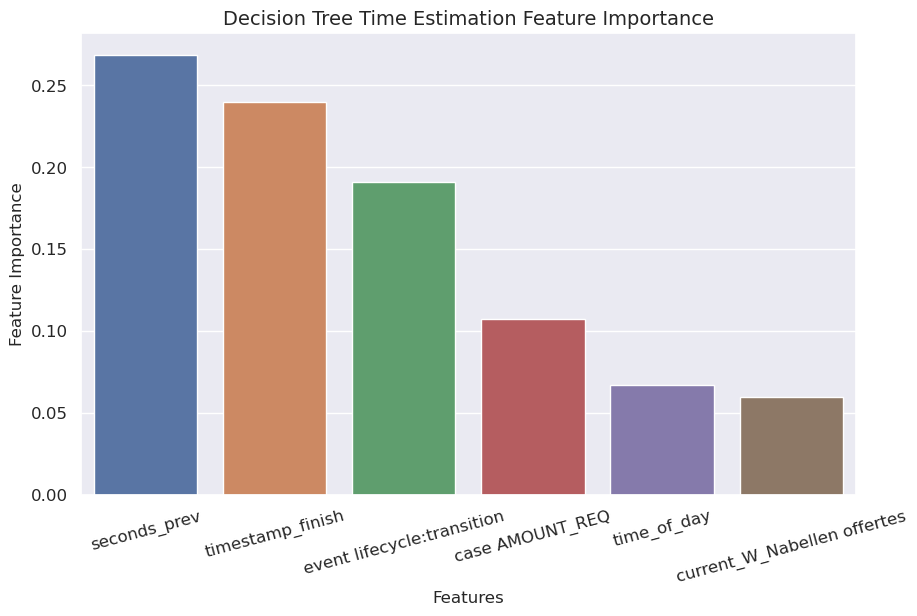

In [72]:
important_features = filter_features(dt_time_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Decision Tree Time Estimation Feature Importance')


### Bar chart feature importance Decision Tree event estimator

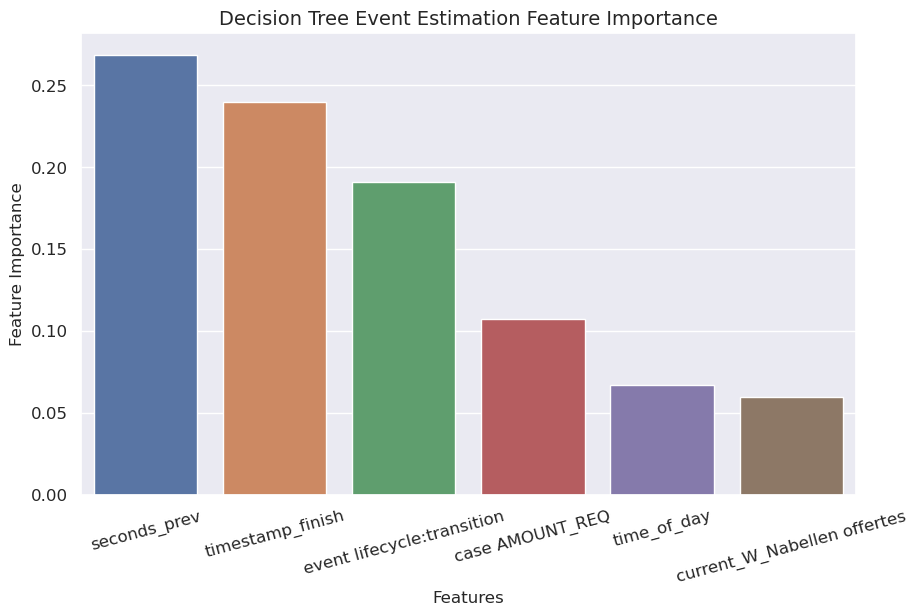

In [73]:
important_features = filter_features(dt_time_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Decision Tree Event Estimation Feature Importance')


### Residual plot for RF time

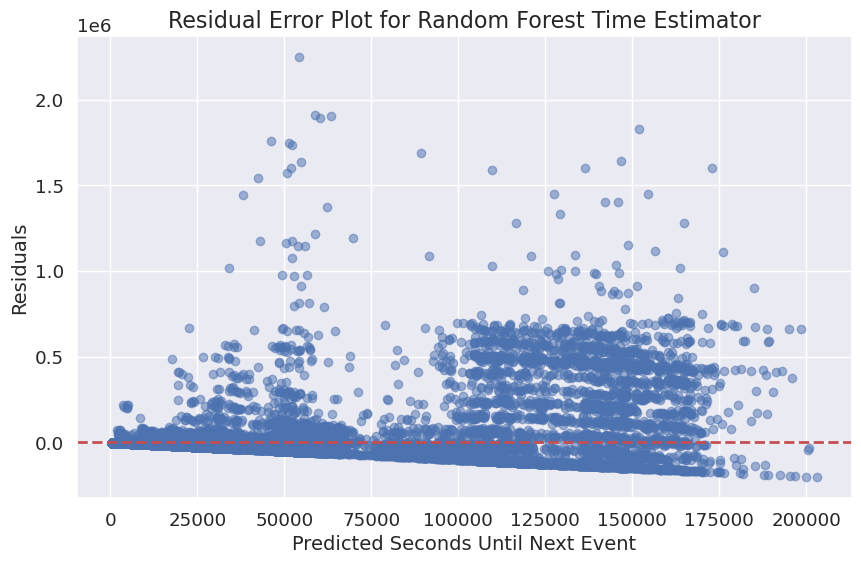

In [74]:
y_pred_time = rf_time.predict(X_test_time)

# Calculate residuals
residuals = y_test_time - y_pred_time

# Create a scatter plot of the predicted values vs. residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_time, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel('Predicted Seconds Until Next Event', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual Error Plot for Random Forest Time Estimator', fontsize=16)
plt.show()

## Time measurement for event and time predictions

In [75]:
# Function for measuring runtime for event estimation
def measure_runtime_event(model, X_train, y_train, X_val, y_val, X_test, y_test):
    start_train = timeit.default_timer()
    rf_event_train = rf_event.predict(X_train_event)
    end_train = timeit.default_timer()
    train_time = end_train - start_train

    start_val = timeit.default_timer()
    rf_event_val = rf_event.predict(X_val_event)
    end_val = timeit.default_timer()
    val_time = end_val - start_val

    start_test = timeit.default_timer()
    rf_event_test = rf_event.predict(X_test_event)
    end_test = timeit.default_timer()
    test_time = end_test - start_test

    print(f"Training time: {train_time:.4f} seconds")
    print(f"Validation time: {val_time:.4f} seconds")
    print(f"Testing time: {test_time:.4f} seconds")

# Function for measuring runtime for time estimation
def measure_runtime_time(model, X_train, y_train, X_val, y_val, X_test, y_test):
    start_train = timeit.default_timer()
    rf_time_train = rf_time.predict(X_train_time)
    #model.fit(X_train, y_train)
    end_train = timeit.default_timer()
    train_time = end_train - start_train

    start_val = timeit.default_timer()
    rf_time_val = rf_time.predict(X_val_time)
    #model.predict(X_val)
    end_val = timeit.default_timer()
    val_time = end_val - start_val

    start_test = timeit.default_timer()
    rf_time_test = rf_time.predict(X_test_time)
    #model.predict(X_test)
    end_test = timeit.default_timer()
    test_time = end_test - start_test

    print(f"Training time: {train_time:.4f} seconds")
    print(f"Validation time: {val_time:.4f} seconds")
    print(f"Testing time: {test_time:.4f} seconds")

# Measure runtime for the random forest event estimator
print("Random Forest Event Estimator Runtime:")
measure_runtime_event(rf_event, X_train_event, y_train_event, X_val_event, y_val_event, X_test_event, y_test_event)

# Measure runtime for the random forest time estimator
print("\nRandom Forest Time Estimator Runtime:")
measure_runtime_time(rf_time, X_train_time, y_train_time, X_val_time, y_val_time, X_test_time, y_test_time)


Random Forest Event Estimator Runtime:
Training time: 10.9255 seconds
Validation time: 2.8916 seconds
Testing time: 3.2818 seconds

Random Forest Time Estimator Runtime:
Training time: 3.7865 seconds
Validation time: 1.1039 seconds
Testing time: 1.2316 seconds


In [76]:
# stop measuring time
end = time.time()
print('Runtime of the complete tool in minutes: ', (end - start_time)/60)

Runtime of the complete tool in minutes:  21.30636713107427
